In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [14]:
tickers = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", "PG", "PGR", "NEM", "CCI"]

start_date = '2017-01-03'
end_date = '2021-09-01'

# panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [15]:
# close = panel_data['Close']
# adj_close = panel_data['Adj Close']

## Function that saves dataframe to CSV

In [41]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [42]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
    close = panel_data['Close']
    adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('close', close, ticker)
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [43]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [44]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [45]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [46]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

In [48]:
port_list = ["AMD", "CPRT"]
mult_df = merge_df_by_column_name('daily_return', '2018-01-02', 
                                  '2021-09-10', *port_list)
mult_df

,AMD,CPRT
Date,,
2018-01-02,NaN,NaN
2018-01-03,0.051913,-0.004816
2018-01-04,0.049351,0.008066
2018-01-05,-0.019802,-0.004801
2018-01-08,0.033670,0.000459
...,...,...
2021-08-26,-0.009511,-0.006670
2021-08-27,0.038501,0.010282
2021-08-30,-0.000718,0.000069


## Get stock prices on date

In [49]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [50]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [59]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [60]:
port_list = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", "PG", "PGR", "NEM", "CCI"]

port_shares = []

tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
                                    port_shares, port_list)
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total,daily_return
Date,,,,,,,,,,,,,
2020-01-02,2550.250053,1869.600067,2795.729996,1276.599960,271.799988,490.429993,325.073303,116.849655,335.733337,1138.325546,400.082199,11570.474098,NaN
2020-01-03,2541.749954,1853.200073,2762.389938,1263.599960,272.709991,494.470001,330.254120,116.063782,335.688210,1128.053482,402.284821,11500.464333,-0.006051
2020-01-06,2531.250000,1869.799957,2740.551910,1258.139984,278.089996,497.450012,332.233337,116.224739,341.785889,1139.378922,398.896225,11503.800972,0.000290
2020-01-07,2572.500038,1867.400055,2748.413849,1254.500000,279.489990,499.160004,326.528625,115.505127,339.175377,1138.588730,392.147232,11533.409027,0.002574
2020-01-08,2500.749969,1880.200043,2761.370941,1243.580048,283.119995,500.769989,324.782257,115.997498,341.179924,1108.300293,393.785065,11453.836021,-0.006899
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,5829.999924,2474.199982,4344.710297,2387.059937,462.130005,656.489990,366.690155,133.619568,459.941788,1621.207306,448.480408,19184.529358,0.012502
2020-12-28,5825.999832,2534.400024,4271.513367,2381.599960,463.589996,651.900024,366.493958,134.550980,459.052849,1603.515472,455.032883,19147.649345,-0.001922
2020-12-29,5534.249878,2518.399963,4254.419525,2356.120071,447.589996,664.979980,371.986298,134.298737,457.041130,1601.103027,453.751511,18793.940117,-0.018473


## Get old data for portfolio

In [61]:
tot_port_df = get_port_daily_return('2017-01-03', '2020-12-31', 
                                    port_shares, port_list)
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total,daily_return
Date,,,,,,,,,,,,,
2018-01-02,1200.749969,871.999969,1941.664154,285.479988,80.440002,348.970001,190.319305,80.641106,234.782867,950.174164,285.789276,6471.010803,NaN
2018-01-03,1243.249989,867.799988,1943.686203,300.300005,81.029999,353.029999,190.770508,80.543259,234.655647,942.205917,284.582451,6521.853964,0.007857
2018-01-04,1251.749992,874.800034,1955.095749,315.119997,83.110001,349.790009,191.973770,81.112587,234.613247,952.663940,281.276642,6571.305967,0.007583
2018-01-05,1260.249996,870.599976,1972.860474,308.880003,83.879997,350.880005,193.853836,81.165970,235.503826,956.150162,283.428040,6597.452284,0.003979
2018-01-08,1238.249969,870.999985,1992.502731,319.279993,84.639999,356.549988,194.060654,81.592964,236.224747,955.154037,284.267601,6613.522669,0.002436
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,5829.999924,2474.199982,4344.710297,2387.059937,462.130005,656.489990,366.690155,133.619568,459.941788,1621.207306,448.480408,19184.529358,0.012502
2020-12-28,5825.999832,2534.400024,4271.513367,2381.599960,463.589996,651.900024,366.493958,134.550980,459.052849,1603.515472,455.032883,19147.649345,-0.001922
2020-12-29,5534.249878,2518.399963,4254.419525,2356.120071,447.589996,664.979980,371.986298,134.298737,457.041130,1601.103027,453.751511,18793.940117,-0.018473


## Forecasting

In [62]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09',
               '2018-01-10', '2018-01-11',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1095, freq='D')

In [63]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [71]:
tot_port_df

,Total,daily_return
Date,,
2018-01-02,6471.010803,NaN
2018-01-03,6521.853964,0.007857
2018-01-04,6571.305967,0.007583
2018-01-05,6597.452284,0.003979
2018-01-06,6597.452284,0.003979
...,...,...
2020-12-27,19184.529358,0.012502
2020-12-28,19147.649345,-0.001922
2020-12-29,18793.940117,-0.018473


In [72]:
# Delete all unneeded columns
# del_col = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", 
#              "PG", "PGR", "NEM", "CCI", "daily_return"]
# for x in del_col:
#     tot_port_df = tot_port_df.drop([x], axis=1)
    
tot_port_df.drop(columns=['daily_return'], inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1095


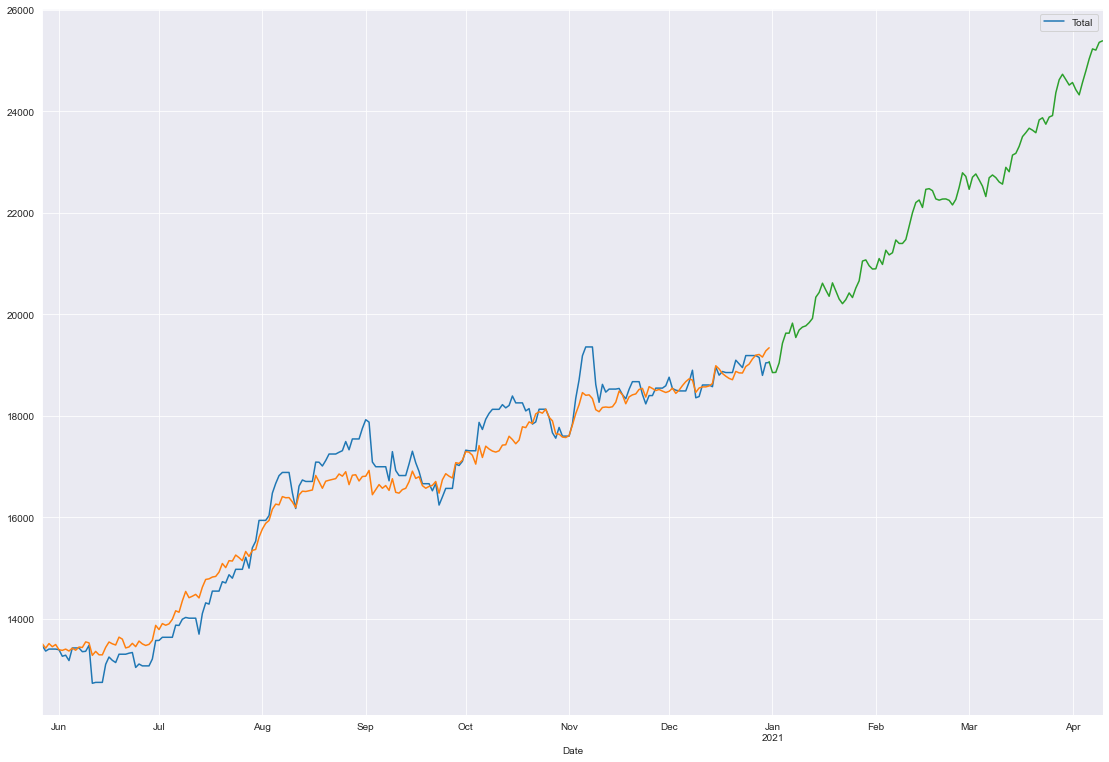

In [144]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:876] # First 80% 
test_df = tot_port_df.iloc[876:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 219).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # Orange
ax = prediction.plot(ax=ax) # Green

# Predict 100 days into the future
forecast = train_model.predict(start=end, end=end+100, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [145]:
forecast

2020-12-31    19064.316035
2021-01-01    18849.405876
2021-01-02    18853.236501
2021-01-03    19039.668716
2021-01-04    19428.154155
                  ...     
2021-04-06    25032.793670
2021-04-07    25229.193536
2021-04-08    25205.639471
2021-04-09    25358.034003
2021-04-10    25388.069103
Freq: D, Length: 101, dtype: float64

In [146]:
import itertools

In [147]:
test_df

,Total
Date,
2020-05-27,13466.799454
2020-05-28,13360.005547
2020-05-29,13399.514999
2020-05-30,13399.514999
2020-05-31,13399.514999
...,...
2020-12-27,19184.529358
2020-12-28,19147.649345
2020-12-29,18793.940117


In [148]:
forecast = []
for num in prediction:
    forecast.append(num)

In [149]:
actual = []

for num in test_df['Total']:
    actual.append(num)

In [150]:
forecast

[13503.053108475719,
 13417.917155797193,
 13507.788238639121,
 13445.762808159088,
 13489.009433900615,
 13386.214533702485,
 13374.148818797403,
 13398.888880899833,
 13361.067602409279,
 13417.556352079671,
 13376.799351865688,
 13439.64395423405,
 13431.02684001945,
 13541.131425884449,
 13521.949690827925,
 13275.801845792601,
 13353.605567920447,
 13286.533916176872,
 13285.53875121428,
 13432.994159899856,
 13539.060687972444,
 13503.051901319419,
 13479.657062504033,
 13634.438089259525,
 13595.782800347488,
 13422.022077516787,
 13441.368401688713,
 13512.277917812768,
 13447.422120157218,
 13557.188912384954,
 13501.25388690848,
 13470.444369324883,
 13491.75591988623,
 13572.880490553307,
 13866.682867769548,
 13783.860976063504,
 13901.691862875201,
 13869.288890873304,
 13896.482094560379,
 13986.324135571587,
 14154.030493153985,
 14125.282046173534,
 14349.645230814604,
 14535.460239459642,
 14411.898885147413,
 14441.325252990913,
 14477.506452401338,
 14407.45024234356

In [151]:
actual

[13466.799453735352,
 13360.005546569824,
 13399.514999389648,
 13399.514999389648,
 13399.514999389648,
 13386.555862426758,
 13257.748374938965,
 13278.97127532959,
 13172.634147644043,
 13421.099388122559,
 13421.099388122559,
 13421.099388122559,
 13348.121444702148,
 13355.414123535156,
 13473.267036437988,
 12725.236000061035,
 12742.850204467773,
 12742.850204467773,
 12742.850204467773,
 13098.906044006348,
 13242.631301879883,
 13177.6109085083,
 13133.919891357422,
 13298.091186523438,
 13298.091186523438,
 13298.091186523438,
 13318.316566467285,
 13331.81420135498,
 13036.97322845459,
 13104.934997558594,
 13068.151176452637,
 13068.151176452637,
 13068.151176452637,
 13203.85912322998,
 13567.843086242676,
 13569.999900817871,
 13631.682907104492,
 13631.682907104492,
 13631.682907104492,
 13631.682907104492,
 13870.67837524414,
 13865.352073669434,
 13987.79704284668,
 14022.72964477539,
 14008.319847106934,
 14008.319847106934,
 14008.319847106934,
 13693.251243591309,
 

In [152]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(219):

	# Calculate percentage error
	per_err = (actual[day] - forecast[day]) / actual[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')



MAPE : 0.02
MAPE % : 1.79 %

